In [ ]:
%env THEANO_FLAGS=device=gpu4,floatX=float32,exception_verbosity=high,lib.cnmem=0.7,mode=FAST_RUN
%run ./dimanet-critic.ipynb

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

env: THEANO_FLAGS=device=gpu4,floatX=float32,exception_verbosity=high,lib.cnmem=0.7,mode=FAST_RUN


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 4: GeForce GTX 1080 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5110)


Some examples ['ejaculate', 'l3i+ch', 'unhappy', 'schlong', 'messy', 's_h_i_t', 'bitchin', 'porno', 'kums', 'assnigger']
Number of target words 238


('Most rewarded answer: ', ['he', "'", 's', 'a', 'adjustments', ',', 'a', 'lily', 'and', 'a', 'dog', 'thief', '!', '_EOS_'])
('Input phrase: ', ['one', 'day', 'you', "'", 're', 'stealing', 'an', 'egg', ',', 'the', 'next', 'you', "'", 're', 'stealing', 'a', 'cow', ',', 'and', 'then', 'you', "'", 'll', 'be', 'killing', 'your', 'mother', '!'])
('Correct answer: ', ['what', '?'])


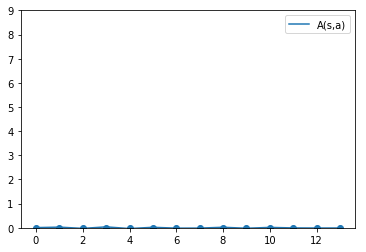

Answers on test phrases:
Processed 490/294454 batches in current epoch
Critic Loss (averaged with last 10 batches): 7.52784
Avg reward: -0.06250
Loss history:


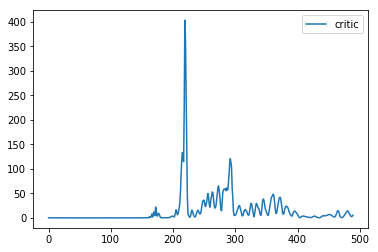

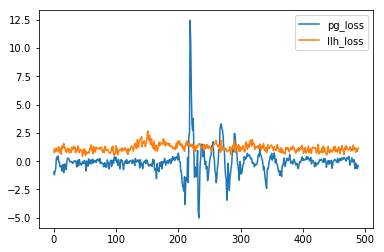

('Phrase:\t', ['Hello! How are you?'])
('Answer:\t',)
('"hello"(0.001) ',)
('"."(0.027) ',)
('Phrase:\t', ['How old are you?'])
('Answer:\t',)
('"around"(0.037) ',)
('"it"(-0.019) ',)
('"just"(0.029) ',)
('"."(0.032) ',)
('Phrase:\t', ['Are you fucking kidding me?'])
('Answer:\t',)
('"you"(-0.008) ',)
('"\'"(-0.016) ',)
('"re"(0.016) ',)
('"in"(0.006) ',)
('"love"(0.005) ',)
('"with"(0.029) ',)
('"him"(0.024) ',)
('","(0.021) ',)
('"_UNK_"(0.012) ',)
('"."(0.006) ',)
('Phrase:\t', ['Suck. What are you doing?'])
('Answer:\t',)
('"there"(0.009) ',)
('"."(-0.008) ',)
('Phrase:\t', ['You are piece of shit!!!'])
('Answer:\t',)
('"relax"(-0.010) ',)
('"."(-0.010) ',)
('Phrase:\t', ['holy fucking crap. you are motherfucker'])
('Answer:\t',)
('"don"(-0.004) ',)
('"\'"(0.017) ',)
('"t"(-0.013) ',)
('"go"(0.015) ',)
('"!"(-0.010) ',)
---------------
Answers on 'hello world!':
hello , sylvia .
good heavens !
_UNK_ !
you ' re coming with me .
there you go , nick , and i ' m glad you said that .
TR

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

test_phrases = [['Hello! How are you?'],
                ['How old are you?'],
                ['Are you fucking kidding me?'],
                ['Suck. What are you doing?'], 
                ['You are piece of shit!!!'], 
                ['holy fucking crap. you are motherfucker']]

test_phrases_ids = phrase2matrix(test_phrases)

from agentnet.utils.persistence import save,load
load(Gen.recurrence, './weights/LM3.pkl')

BATCH_SIZE = 64
TRAINING_TIME_IN_BATCHES = 500
VERBOSITY = 10 # number of batches before printing
NUM_BATCHES = len(contexts)//BATCH_SIZE
LLH_ALPHA = 20.0
SAVE_EVERY = 100
MODELS_SUFFIX = '_bepolite_my_lm'

AT.LLH_ALPHA.set_value(LLH_ALPHA)
train_contexts = contexts[:-10000]
valid_contexts = contexts[-10000:]

loss_history = {'critic':[], 'pg_loss':[], 'llh_loss':[]}
rewards_history = []
for nb, (batch_context, batch_answers) in enumerate(iterate_minibatches(train_contexts, BATCH_SIZE)):
    if (nb + 1) >= TRAINING_TIME_IN_BATCHES:
        print("TRAINING FINISHED!")
        break
    
    ## Training stuff.
    pg_loss, llh_loss, policy, actions, advantage, rewards, is_alive = AT.train_step(batch_context, batch_answers)
    critic_loss, _, _, _, _ = CT.train_step(batch_context)

    loss_history['critic'].append(critic_loss)
    loss_history['pg_loss'].append(pg_loss)
    loss_history['llh_loss'].append(llh_loss)
    rewards_history.append(rewards.sum(axis=1).mean())

    #### PRINTING STUFF. ####
    if (nb + 1) % VERBOSITY == 0:
        clear_output(wait=True) 

        # Visualize answer with maximum reward.
        idx = np.argmax((rewards*is_alive).sum(axis=1))
        ans_seq, ans_rewards, ans_advantage = actions[idx], rewards[idx], advantage[idx]
        answer_len = list(ans_seq).index(EOS_ix) if EOS_ix in ans_seq else len(ans_seq)

        ans = [tokens[i] for i in ans_seq][:answer_len+1]
        inp_phrase = [tokens[i] for i in batch_context[idx][:list(batch_context[idx]).index(EOS_ix)]]
        corr_ans = [tokens[i] for i in batch_answers[idx][:list(batch_answers[idx]).index(EOS_ix)]]
        print("Most rewarded answer: ", ans)
        print("Input phrase: ", inp_phrase)
        print("Correct answer: ", corr_ans)
        plt.scatter(range(len(ans_rewards[:answer_len+1])), ans_rewards[:answer_len+1])
#             plt.plot(ans_V_pred[:answer_len+1], label='predicted')
#             plt.plot(ans_V_ref[:answer_len+1], label='reference')
        plt.plot(ans_advantage[:answer_len+1], label='A(s,a)')
        plt.ylim(ymin=0)
        plt.yticks(np.arange(10))
        plt.legend()
        plt.show()

        # Answering on test phrases.
        print("Answers on test phrases:")
        words_seq, critic_values, _, _ = Critic.predict(test_phrases_ids)
        answers = []
        for i in range(words_seq.shape[0]):
            answer = words_seq[i]
            if EOS_ix in answer:
                answer = answer[:list(answer).index(EOS_ix)]
            answers.append([tokens[idx] for idx in answer])

        print("Processed {}/{} batches in current epoch".format(nb+1, NUM_BATCHES))
        print("Critic Loss (averaged with last 10 batches): {0:.5f}".format(np.mean(loss_history['critic'][-10:])))
#             print("Actor Loss (averaged with last 10 batches): {0:.5f}".format(np.mean(loss_history['actor'][-10:])))
        print("Avg reward: {0:.5f}".format(np.mean(rewards_history[-10:])))
        print("Loss history:")
        plt.plot(loss_history['critic'], label='critic')
        plt.legend()
        plt.show()
        plt.plot(loss_history['pg_loss'], label=r'pg_loss')
        plt.plot(loss_history['llh_loss'], label=r'llh_loss')
        plt.legend()
        plt.show()

        for i in range(len(test_phrases)):
            print("Phrase:\t", test_phrases[i])
            answer_tok_critic_value = zip(answers[i], critic_values[i])
            print("Answer:\t",)
            for tok,value in answer_tok_critic_value:
                print('"{}"({:.3f}) '.format(tok, value),)
        print('---'*5)
        print("Answers on 'hello world!':")
        for i in range(5):
            print(Gen.reply('hello world!'))

    if nb % SAVE_EVERY == 0:
        criticfname = './weights/critic{}{}.pkl'.format(MODELS_SUFFIX, LLH_ALPHA)
        actorfname = './weights/actor{}{}.pkl'.format(MODELS_SUFFIX, LLH_ALPHA)
        print("Save actor and critic weights to '{}' and '{}'".format(criticfname, actorfname))
        save(Critic.l_critic_values, criticfname)
        save(Gen.recurrence, actorfname)

In [4]:
import pickle

with open('rewards{}.pkl'.format(LLH_ALPHA), 'wb') as fout:
    pickle.dump(rewards_history, fout)
with open('loss_history{}.pkl'.format(LLH_ALPHA), 'wb') as fout:
    pickle.dump(loss_history, fout)

In [9]:
import pandas as pd

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.1).mean()
  if __name__ == '__main__':


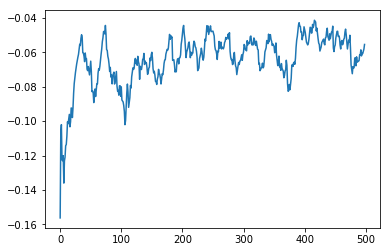

In [16]:
plt.plot(pd.ewma(pd.Series(rewards_history), alpha=0.1))

# Reward comparison

## 1. Baseline seq2seq

In [ ]:
from agentnet.utils.persistence import load
get_rewards = theano.function([Enc.input_phrase], [Critic.rewards, Gen.words_seq], allow_input_downcast=True, no_default_updates=True)

# load(Gen.recurrence,"pretrained_network/weights.pcl")
load(Gen.recurrence, './weights/LM3.pkl')

In [18]:
for _ in range(10):
    print(Gen.reply('get the fuck out!'))

they ' re coming here now .
what ' s happened ?
_UNK_ - is reggae ?
johnny . . .
shut up !
come , george .
he was a wounded politician .
who is he ?
forget _UNK_ i told you i could not stop by the ball .
damn right , that is right .


In [19]:
def get_rewards_and_llh(batch_size=64):
    rewards = []
    llhs = []

    for nb, (batch_context, batch_answers) in tqdm.tqdm_notebook(enumerate(iterate_minibatches(valid_contexts, batch_size))):
        b_rewards, b_answers = get_rewards(batch_context)
        rewards.extend(list(b_rewards.sum(axis=1)))
        llhs.append(GenTrain.get_llh(batch_context, batch_answers))
    return rewards, llhs

In [20]:
rewards, llhs = get_rewards_and_llh(64)

In [21]:
np.exp(np.mean(llhs)), np.mean(rewards)

(3.1428001, -0.13671875)

### Now calculate reward over batches where input contains obscene.

In [ ]:
BATCH_SIZE = 400
NUM_BATCHES = 1000
rewards = []


for nb, (batch_context, batch_answers) in tqdm.tqdm_notebook(enumerate(iterate_minibatches(contexts, BATCH_SIZE))):
    if nb >= NUM_BATCHES:
        break
    mask = (batch_context[:, :, None] == np.array(list(target_idxs))[None, None, :]).any(-1).any(-1)
    bb = batch_context[mask]
        
    b_rewards, b_answers = get_rewards(bb)
    rewards.extend(list(b_rewards.sum(axis=1)))

In [ ]:
np.mean(rewards)

## 2. A2C finetuned seq2seq

In [22]:
load(Gen.recurrence,"./weights/actor_bepolite_my_lm20.0.pkl")

In [23]:
rewards, llhs = get_rewards_and_llh(batch_size=64)

In [24]:
np.exp(np.mean(llhs)), np.mean(rewards)

(3.2717564, -0.065204326923076927)

In [ ]:
for _ in range(10):
    print(Gen.reply('get the fuck out!'))

### Again, over batches where input contains obscene.

In [ ]:
BATCH_SIZE = 400
NUM_BATCHES = 1000
rewards = []

for nb, (batch_context, batch_answers) in tqdm.tqdm_notebook(enumerate(iterate_minibatches(contexts, BATCH_SIZE))):
    if nb >= NUM_BATCHES:
        break
    mask = (batch_context[:, :, None] == np.array(list(target_idxs))[None, None, :]).any(-1).any(-1)
    bb = batch_context[mask]
        
    b_rewards, b_answers = get_rewards(bb)
    rewards.extend(list(b_rewards.sum(axis=1)))

In [ ]:
np.mean(rewards)